In [1]:
# Cell 1: Import required libraries
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import label, generate_binary_structure
from scipy.stats import ttest_ind

# Define paths
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
gca_dir = f'{results_dir}/gca_group_averages_exp2'  # Directory with your thresholded GCA images
output_dir = f'{results_dir}/gca_quantitative_exp2'
os.makedirs(output_dir, exist_ok=True)

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Cell 2: Load thresholded GCA images
def load_thresholded_images():
    """Load previously thresholded GCA images"""
    thresholded_imgs = {}
    
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            for hemi in ['left', 'right']:
                img_path = f'{gca_dir}/{condition}_{roi}_{hemi}_gca_thresh.nii.gz'
                if os.path.exists(img_path):
                    thresholded_imgs[f"{condition}_{roi}_{hemi}"] = nib.load(img_path)
                else:
                    print(f"Warning: {img_path} not found")
    
    return thresholded_imgs

thresholded_imgs = load_thresholded_images()
print(f"Loaded {len(thresholded_imgs)} thresholded GCA images")

Loaded 8 thresholded GCA images


In [ ]:
# Cell 3: Calculate Dice coefficients to compare spatial patterns
def calculate_dice_coefficients(thresholded_imgs):
    """
    Calculate Dice coefficients for:
    1. Tool vs Nontool (same ROI+hemisphere)
    2. pIPS vs LO (same condition+hemisphere)
    """
    dice_coefficients = {}
    
    # Tool vs Nontool for same ROI+hemisphere
    for roi in ['pIPS', 'LO']:
        for hemi in ['left', 'right']:
            tool_key = f"tool_{roi}_{hemi}"
            nontool_key = f"nontool_{roi}_{hemi}"
            
            if tool_key in thresholded_imgs and nontool_key in thresholded_imgs:
                tool_data = thresholded_imgs[tool_key].get_fdata() != 0
                nontool_data = thresholded_imgs[nontool_key].get_fdata() != 0
                
                # Calculate Dice
                intersection = np.sum(tool_data & nontool_data)
                dice = 2 * intersection / (np.sum(tool_data) + np.sum(nontool_data))
                
                dice_coefficients[f"{roi}_{hemi}_tool_vs_nontool"] = dice
    
    # pIPS vs LO for same condition+hemisphere
    for condition in ['tool', 'nontool']:
        for hemi in ['left', 'right']:
            pips_key = f"{condition}_pIPS_{hemi}"
            lo_key = f"{condition}_LO_{hemi}"
            
            if pips_key in thresholded_imgs and lo_key in thresholded_imgs:
                pips_data = thresholded_imgs[pips_key].get_fdata() != 0
                lo_data = thresholded_imgs[lo_key].get_fdata() != 0
                
                # Calculate Dice
                intersection = np.sum(pips_data & lo_data)
                dice = 2 * intersection / (np.sum(pips_data) + np.sum(lo_data))
                
                dice_coefficients[f"{condition}_{hemi}_pIPS_vs_LO"] = dice
    
    return dice_coefficients

dice_coefficients = calculate_dice_coefficients(thresholded_imgs)

# Create DataFrame for display
dice_df = pd.DataFrame([
    {
        'Comparison': key,
        'Dice Coefficient': value
    }
    for key, value in dice_coefficients.items()
])

dice_df

,Comparison,Dice Coefficient
0,pIPS_left_tool_vs_nontool,0.476508
1,pIPS_right_tool_vs_nontool,0.496619
2,LO_left_tool_vs_nontool,0.640070
3,LO_right_tool_vs_nontool,0.577783
4,tool_left_pIPS_vs_LO,0.375853
5,tool_right_pIPS_vs_LO,0.359907
6,nontool_left_pIPS_vs_LO,0.323397
7,nontool_right_pIPS_vs_LO,0.359418


Loaded merged atlas with 202 regions
Loading thresholded GCA images...
  Loaded: tool_pIPS_left
  Loaded: tool_pIPS_right
  Loaded: tool_LO_left
  Loaded: tool_LO_right
  Loaded: nontool_pIPS_left
  Loaded: nontool_pIPS_right
  Loaded: nontool_LO_left
  Loaded: nontool_LO_right

Analyzing GCA data with atlas-based approach...
Classified 131 dorsal regions and 52 ventral regions
Creating simplified GCA directionality visualization...


ValueError: Image size of 107300x2400 pixels is too large. It must be less than 2^16 in each direction.

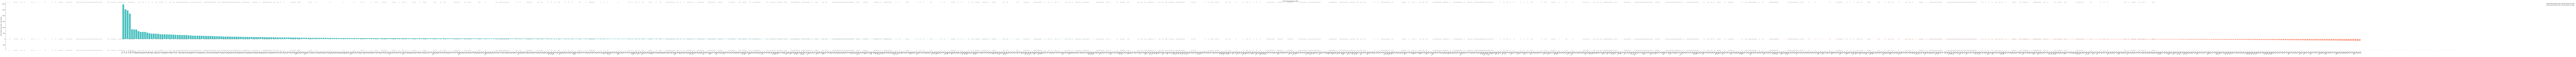

In [21]:
# Cell 4: GCA Anatomical Organization Analysis for Experiment 2
# Adapting the atlas-based fingerprint approach for GCA directionality analysis

import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch
from scipy.ndimage import label, generate_binary_structure
import seaborn as sns

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/gca_anatomical_analysis_exp2'
os.makedirs(output_dir, exist_ok=True)

# Load merged atlas for region categorization
merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'
merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'

if os.path.exists(merged_atlas_file) and os.path.exists(merged_labels_file):
    atlas_img = nib.load(merged_atlas_file)
    atlas_data = atlas_img.get_fdata()
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas with {len(atlas_labels)} regions")
else:
    print("Warning: Merged atlas not found. Region-based analysis will be limited.")
    atlas_img = None
    atlas_data = None
    atlas_labels = []

# Function to map ROI names to anatomical lobes - reused from FC/PPI script
def map_to_anatomical_lobe(roi_name):
    # Special handling for Wang atlas ROIs
    if 'Wang_pIPS' in roi_name:
        return 'Parietal'
    elif 'Wang_LO' in roi_name:
        return 'Temporal'
    
    # Map Schaefer networks to anatomical regions
    if 'Vis' in roi_name:
        return 'Occipital'
    elif 'SomMot' in roi_name:
        return 'Somatomotor'
    elif 'DorsAttn' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        else:
            return 'Parietal'
    elif 'SalVentAttn' in roi_name:
        if 'Ins' in roi_name:
            return 'Insular'
        elif 'Cing' in roi_name or 'ACC' in roi_name:
            return 'Cingulate'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'Par' in roi_name:
            return 'Parietal'
        else:
            return 'Frontal'
    elif 'Limbic' in roi_name:
        if 'Temp' in roi_name:
            return 'Temporal'
        else:
            return 'Frontal'
    elif 'Cont' in roi_name:
        if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name or 'MT' in roi_name:
            return 'Temporal'
        elif 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    elif 'Default' in roi_name:
        if 'Par' in roi_name:
            return 'Parietal'
        elif 'Temp' in roi_name:
            return 'Temporal'
        elif 'PCC' in roi_name or 'Cing' in roi_name:
            return 'Cingulate'
        else:
            return 'Frontal'
    else:
        return 'Other'

# Clean up ROI names - reused from FC/PPI script
def clean_roi_name(roi_name):
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    # Handle Wang ROIs
    if 'Wang_' in roi_name:
        return roi_name.replace('Wang_', '')
    
    # Remove common prefixes and suffixes
    cleaned = roi_name.replace('7Networks_', '')
    
    # Extract just the region part, removing hemisphere and network
    parts = cleaned.split('_')
    if len(parts) > 2:
        return parts[-2] + '_' + parts[-1]
    elif len(parts) > 1:
        return parts[-1]
    else:
        return cleaned

# Helper function to extract hemisphere information
def get_hemisphere_from_name(roi_name):
    if isinstance(roi_name, bytes):
        roi_name = roi_name.decode('utf-8')
    
    if 'LH' in roi_name:
        return 'L'
    elif 'RH' in roi_name:
        return 'R'
    else:
        return 'X'  # Bilateral or unknown

# Load GCA thresholded images
def load_gca_thresholded_images():
    """Load thresholded GCA maps from Experiment 2"""
    print("Loading thresholded GCA images...")
    
    gca_dir = f'{results_dir}/gca_group_averages_exp2'
    thresholded_imgs = {}
    
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            for hemi in ['left', 'right']:
                img_path = f'{gca_dir}/{condition}_{roi}_{hemi}_gca_thresh.nii.gz'
                if os.path.exists(img_path):
                    thresholded_imgs[f"{condition}_{roi}_{hemi}"] = nib.load(img_path)
                    print(f"  Loaded: {condition}_{roi}_{hemi}")
                else:
                    print(f"  Not found: {img_path}")
    
    return thresholded_imgs

# Analyze GCA data using atlas-based approach
def analyze_gca_with_atlas(thresholded_imgs, atlas_img, atlas_labels):
    """Analyze GCA data using atlas regions for anatomical organization"""
    print("\nAnalyzing GCA data with atlas-based approach...")
    
    # Define which atlas regions are considered dorsal vs ventral
    dorsal_indices = []
    ventral_indices = []
    
    for i, label in enumerate(atlas_labels):
        label_str = str(label)
        lobe = map_to_anatomical_lobe(label_str)
        
        # Classify as dorsal (parietal, frontal) or ventral (temporal, occipital)
        if lobe in ['Parietal', 'Frontal', 'Somatomotor']:
            dorsal_indices.append(i)
        elif lobe in ['Temporal', 'Occipital']:
            ventral_indices.append(i)
    
    print(f"Classified {len(dorsal_indices)} dorsal regions and {len(ventral_indices)} ventral regions")
    
    # Initialize results structure
    atlas_results = {}
    
    # Load atlas data
    atlas_data = atlas_img.get_fdata()
    
    # Process each GCA map
    for key, img in thresholded_imgs.items():
        # Parse key components
        condition, roi, hemi = key.split('_')
        
        # Get GCA data
        gca_data = img.get_fdata()
        
        # Dictionary to store region-specific results
        region_results = {}
        
        # Analyze each region in the atlas
        for i, label in enumerate(atlas_labels):
            region_idx = i + 1  # Atlas indices are 1-based
            region_mask = atlas_data == region_idx
            
            # Skip if no voxels from this region
            if np.sum(region_mask) == 0:
                continue
            
            # Extract GCA values within this region
            region_gca = gca_data[region_mask]
            
            # Count positive and negative voxels
            pos_voxels = np.sum(region_gca > 0)
            neg_voxels = np.sum(region_gca < 0)
            
            # Calculate mean positive and negative values
            pos_mean = np.mean(region_gca[region_gca > 0]) if pos_voxels > 0 else 0
            neg_mean = np.mean(region_gca[region_gca < 0]) if neg_voxels > 0 else 0
            
            # Store region information
            region_name = str(label)
            lobe = map_to_anatomical_lobe(region_name)
            hemisphere = get_hemisphere_from_name(region_name)
            is_dorsal = i in dorsal_indices
            is_ventral = i in ventral_indices
            
            # Store region results
            region_results[region_idx] = {
                'ROI_Name': region_name,
                'Clean_Name': clean_roi_name(region_name),
                'Anatomical_Lobe': lobe,
                'Hemisphere': hemisphere,
                'Is_Dorsal': is_dorsal,
                'Is_Ventral': is_ventral,
                'Pos_Voxels': int(pos_voxels),
                'Neg_Voxels': int(neg_voxels),
                'Pos_Mean': float(pos_mean),
                'Neg_Mean': float(neg_mean),
                'Net_Direction': float(pos_voxels - neg_voxels),
                'Total_Voxels': int(pos_voxels + neg_voxels)
            }
        
        # Store in overall results
        atlas_results[key] = region_results
    
    # Calculate directionality metrics
    directionality_metrics = calculate_directionality_metrics(atlas_results)
    
    return atlas_results, directionality_metrics

def calculate_directionality_metrics(atlas_results):
    """Calculate directionality metrics to answer key questions"""
    metrics = {
        'tool': {'pIPS': {}, 'LO': {}},
        'nontool': {'pIPS': {}, 'LO': {}}
    }
    
    for key, region_results in atlas_results.items():
        condition, roi, hemi = key.split('_')
        
        # For pIPS (dorsal seed):
        # - positive values to ventral regions = dorsal-to-ventral flow
        # - negative values to dorsal regions = ventral-to-dorsal flow
        #
        # For LO (ventral seed):
        # - positive values to dorsal regions = ventral-to-dorsal flow
        # - negative values to ventral regions = dorsal-to-ventral flow
        
        dorsal_to_ventral = 0
        ventral_to_dorsal = 0
        
        for region_idx, region_data in region_results.items():
            # Only include regions that have significant GCA effects
            if region_data['Total_Voxels'] == 0:
                continue
                
            if roi == 'pIPS':  # Dorsal seed
                if region_data['Is_Ventral']:
                    # Positive values to ventral regions = dorsal-to-ventral
                    dorsal_to_ventral += region_data['Pos_Voxels']
                elif region_data['Is_Dorsal']:
                    # Negative values to dorsal regions = ventral-to-dorsal
                    ventral_to_dorsal += region_data['Neg_Voxels']
            elif roi == 'LO':  # Ventral seed
                if region_data['Is_Dorsal']:
                    # Positive values to dorsal regions = ventral-to-dorsal
                    ventral_to_dorsal += region_data['Pos_Voxels']
                elif region_data['Is_Ventral']:
                    # Negative values to ventral regions = dorsal-to-ventral
                    dorsal_to_ventral += region_data['Neg_Voxels']
        
        # Update metrics for this condition/ROI/hemisphere
        if roi not in metrics[condition]:
            metrics[condition][roi] = {}
        
        metrics[condition][roi][hemi] = {
            'dorsal_to_ventral': dorsal_to_ventral,
            'ventral_to_dorsal': ventral_to_dorsal,
            'ratio': dorsal_to_ventral / max(1, ventral_to_dorsal)
        }
    
    # Aggregate across hemispheres
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            d2v_total = sum(metrics[condition][roi].get(hemi, {}).get('dorsal_to_ventral', 0) 
                            for hemi in ['left', 'right'])
            v2d_total = sum(metrics[condition][roi].get(hemi, {}).get('ventral_to_dorsal', 0) 
                           for hemi in ['left', 'right'])
            
            metrics[condition][roi]['combined'] = {
                'dorsal_to_ventral': d2v_total,
                'ventral_to_dorsal': v2d_total,
                'ratio': d2v_total / max(1, v2d_total)
            }
    
    return metrics

def create_directionality_dataframe(atlas_results, directionality_metrics):
    """Create a DataFrame summarizing directionality by region"""
    data = []
    
    # Add information from all regions
    for key, region_results in atlas_results.items():
        condition, roi, hemi = key.split('_')
        
        for region_idx, region_data in region_results.items():
            # Skip regions with no significant effects
            if region_data['Total_Voxels'] == 0:
                continue
            
            # Calculate directionality value
            if roi == 'pIPS':  # Dorsal seed
                if region_data['Is_Ventral']:
                    # For ventral regions, positive values indicate dorsal-to-ventral
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Dorsal→Ventral' if direction_value > 0 else 'Ventral→Dorsal'
                elif region_data['Is_Dorsal']:
                    # For dorsal regions, negative values indicate ventral-to-dorsal
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Intra-Dorsal'
                else:
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Other'
            elif roi == 'LO':  # Ventral seed
                if region_data['Is_Dorsal']:
                    # For dorsal regions, positive values indicate ventral-to-dorsal
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Ventral→Dorsal' if direction_value > 0 else 'Dorsal→Ventral'
                elif region_data['Is_Ventral']:
                    # For ventral regions, negative values indicate dorsal-to-ventral
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Intra-Ventral'
                else:
                    direction_value = region_data['Pos_Voxels'] - region_data['Neg_Voxels']
                    direction_type = 'Other'
            
            # Add to data list
            data.append({
                'Condition': condition,
                'Seed_ROI': roi,
                'Hemisphere': hemi,
                'Region_ID': region_idx,
                'Region_Name': region_data['Clean_Name'],
                'Anatomical_Lobe': region_data['Anatomical_Lobe'],
                'Region_Hemisphere': region_data['Hemisphere'],
                'Is_Dorsal': region_data['Is_Dorsal'],
                'Is_Ventral': region_data['Is_Ventral'],
                'Pos_Voxels': region_data['Pos_Voxels'],
                'Neg_Voxels': region_data['Neg_Voxels'],
                'Direction_Value': direction_value,
                'Direction_Type': direction_type,
                'Total_Voxels': region_data['Total_Voxels']
            })
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add summary metrics
    summary_data = []
    for condition in ['tool', 'nontool']:
        for roi in ['pIPS', 'LO']:
            if condition in directionality_metrics and roi in directionality_metrics[condition]:
                metrics = directionality_metrics[condition][roi]['combined']
                summary_data.append({
                    'Condition': condition,
                    'Seed_ROI': roi,
                    'Dorsal_to_Ventral': metrics['dorsal_to_ventral'],
                    'Ventral_to_Dorsal': metrics['ventral_to_dorsal'],
                    'D2V_Ratio': metrics['ratio'],
                    'Total_Significant_Voxels': metrics['dorsal_to_ventral'] + metrics['ventral_to_dorsal']
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    return df, summary_df

def visualize_gca_directionality(directionality_df, summary_df, output_dir):
    """Create simplified bar plot visualization of GCA directionality"""
    print("Creating simplified GCA directionality visualization...")
    
    # Filter for significant ROIs (those with any voxels showing effects)
    sig_df = directionality_df[directionality_df['Total_Voxels'] > 0].copy()
    
    # Sort by direction value (positive to negative)
    sig_df = sig_df.sort_values('Direction_Value', ascending=False)
    
    # Create clean labels
    sig_df['Plot_Label'] = sig_df.apply(
        lambda row: f"{row['Region_Name']}\n({row['Hemisphere']})", axis=1)
    
    # Create figure
    plt.figure(figsize=(max(14, len(sig_df)/3), 8))
    
    # Plot bars colored by direction type
    colors = ['#4ac0c0' if x > 0 else '#ff9b83' for x in sig_df['Direction_Value']]
    bars = plt.bar(range(len(sig_df)), sig_df['Direction_Value'], color=colors)
    
    # Add significance indicators (if you have significance info)
    if 'Significant' in sig_df.columns:
        for i, (_, row) in enumerate(sig_df.iterrows()):
            if not row['Significant']:
                bars[i].set_alpha(0.3)  # Make non-significant bars transparent
    
    # Add labels and title
    plt.xticks(range(len(sig_df)), sig_df['Plot_Label'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Directionality (Pos Voxels - Neg Voxels)')
    plt.title('GCA Directionality by ROI')
    plt.axhline(0, color='black', linewidth=0.8)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='#4ac0c0', label='Dorsal→Ventral (pIPS seed) or Ventral→Dorsal (LO seed)'),
        Patch(facecolor='#ff9b83', label='Ventral→Dorsal (pIPS seed) or Dorsal→Ventral (LO seed)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    
    # Save figure
    fig_path = f'{output_dir}/gca_directionality_simple.png'
    plt.savefig(fig_path, dpi=300)
    plt.close()
    
    print(f"Simplified visualization saved to {fig_path}")
    
    # Print summary of strongest effects
    print("\nStrongest directionality effects:")
    top_pos = sig_df.nlargest(5, 'Direction_Value')
    top_neg = sig_df.nsmallest(5, 'Direction_Value')
    
    print("\nTop positive (D→V for pIPS or V→D for LO):")
    for _, row in top_pos.iterrows():
        print(f"{row['Plot_Label']}: {row['Direction_Value']} (Pos: {row['Pos_Voxels']}, Neg: {row['Neg_Voxels']})")
    
    print("\nTop negative (V→D for pIPS or D→V for LO):")
    for _, row in top_neg.iterrows():
        print(f"{row['Plot_Label']}: {row['Direction_Value']} (Pos: {row['Pos_Voxels']}, Neg: {row['Neg_Voxels']})")

# Main analysis function
def analyze_gca_directionality():
    """Main function to analyze GCA directionality patterns"""
    # Load thresholded GCA images
    thresholded_imgs = load_gca_thresholded_images()
    
    if not thresholded_imgs:
        print("No thresholded GCA images found. Analysis cannot proceed.")
        return
    
    if atlas_img is None or atlas_data is None or len(atlas_labels) == 0:
        print("Atlas data not available. Analysis cannot proceed.")
        return
    
    # Analyze using atlas-based approach
    atlas_results, directionality_metrics = analyze_gca_with_atlas(thresholded_imgs, atlas_img, atlas_labels)
    
    # Create summary DataFrames
    directionality_df, summary_df = create_directionality_dataframe(atlas_results, directionality_metrics)
    
    # Save DataFrames to CSV
    directionality_df.to_csv(f"{output_dir}/gca_directionality_by_region.csv", index=False)
    summary_df.to_csv(f"{output_dir}/gca_directionality_summary.csv", index=False)
    
    # Create visualizations
    visualize_gca_directionality(directionality_df, summary_df, output_dir)
    
    print("\nGCA directionality analysis complete.")
    print(f"Results saved to {output_dir}")
    
    return directionality_df, summary_df

# Run analysis
directionality_df, summary_df = analyze_gca_directionality()